# Fast.ai DataLoader Issue on MNIST

**ISSUE**: A broadcasting error is occuring 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from pathlib import Path
import os
import struct   # for IDX conversion
import gzip     # for IDX conversion
from urllib.request import urlretrieve # for IDX conversion

from fastai.conv_learner import * # if you want to use fastai Learner

In [3]:
PATH = Path('data/mnist')

bs = 64
sz = 28

## PyTorch DataLoader

In [4]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# see: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
# frm: https://github.com/pytorch/pytorch/issues/1106
trainset = torchvision.datasets.MNIST(root=PATH, train=True, download=True,
                                   transform=transform)
validset = torchvision.datasets.MNIST(root=PATH, train=True, download=True,
                                   transform=transform)
testset  = torchvision.datasets.MNIST(root=PATH, train=True, download=True,
                                   transform=transform)
p_val = 0.15
n_val = int(p_val * len(trainset))
idxs  = np.arange(len(trainset))
np.random.shuffle(idxs)
train_idxs, valid_idxs = idxs[n_val:], idxs[:n_val]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idxs)
valid_sampler = torch.utils.data.sampler.SequentialSampler(valid_idxs)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=bs,
                                          sampler=valid_sampler, num_workers=2)
testloader  = torch.utils.data.DataLoader(testset, batch_size=bs, num_workers=2)

## Fast.AI ModelData Object

In [5]:
def read_IDX(fname):
    """see: https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40"""
    with gzip.open(fname) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [6]:
fnames = [o for o in os.listdir(PATH) if 'ubyte.gz' in o] # could just use glob

trn_x_idx = [i for i,s in enumerate(fnames) if 'train-imag' in s][0]
trn_y_idx = [i for i,s in enumerate(fnames) if 'train-lab' in s][0]

# load entire IDX files into memory as ndarrays
train_x_array = read_IDX(PATH/fnames[trn_x_idx])
train_y_array = read_IDX(PATH/fnames[trn_y_idx])

# using same indices as pytorch dataloader
valid_x_array, valid_y_array = train_x_array[valid_idxs], train_y_array[valid_idxs]
train_x_array, train_y_array = train_x_array[train_idxs], train_y_array[train_idxs]

In [7]:
tfms = tfms_from_stats(inception_stats, sz=sz)

model_data = ImageClassifierData.from_arrays(PATH, 
    (train_x_array, train_y_array), (valid_x_array, valid_y_array),
    bs=bs, tfms=tfms, num_workers=2, test=None)

## Error Replication:

### 1.

In [8]:
learner = ConvLearner.pretrained(resnet18, model_data)

In [9]:
learner.lr_find()

  0%|          | 0/797 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (28,28) (3,) 

### 2. 
Narrowing in on the exact cause. The error occurs when the fastai DataLoader attempts to retrieve the next minibatch of data.

In [12]:
x,y = next(iter(model_data.trn_dl))

ValueError: operands could not be broadcast together with shapes (28,28) (3,) 

### 3.

Does this happen with the PyTorch DataLoader? Why not?

In [29]:
# x,y = next(iter(model_data.trn_dl))
x,y = next(iter(trainloader))

In [30]:
x.shape

torch.Size([64, 1, 28, 28])

What happens when I wrap the pytorch dataloader that's different than the fastai dl?

In [31]:
model_data.trn_dl

`model_data`'s `.trn_dl` is created by `ImageData`'s `.get_dl` method during initialization. `ImageData.get_dl(ds, shuf)` creates `ImageData.trn_dl` out of `(trn_ds, True)` whose `trn_ds` object is deconstructed from the `datasets` argument passed into the `ImageData` constructor. When building via `ImageClassifierData.from_arrays` this is created via:
```
datasets = cls.get_ds(ArraysIndexDataset, trn, val, tfms, test=test)
```
(where `cls.get_ds` is the static method `get_ds` of `ImageData`.

---

Perhaps they're using different iterator methods?

[PyTorch DataLoader Iterator](https://pytorch.org/docs/master/_modules/torch/utils/data/dataloader.html?highlight=_DataLoaderIter#DataLoader):
```
class DataLoader(object):
    ...
    ...
    def __iter__(self):
        return _DataLoaderIter(self)
```
$\longrightarrow$
```
class _DataLoaderIter(object):
    r"""Iteratoes once over the DataLoader's dataset, as specified by the sampler"""
    
    def __init__(self, loader):
        self.dataset = loader.dataset
        self. collate_fn = ...
        ...
    ...
```

[FastAI DataLoader Iterator](https://github.com/fastai/fastai/blob/master/fastai/dataloader.py#L80):
```
class DataLoader(object):
    ...
    ...
    def __iter__(self):
        if self.num_workers==0:
            for batch in map(self.get_batch, iter(self.batch_sampler)):
                yield get_tensor(batch, self.pin_memory, self.half)
        else:
            with ThreadPoolExecutor(max_workers=self.num_workers) as e:
                # avoid py3.6 issue where queue is infinite and can result in memory exhaustion
                for c in chunk_iter(iter(self.batch_sampler), self.num_workers*10):
                    for batch in e.map(self.get_batch, c):
                        yield get_tensor(batch, self.pin_memory, self.half)
```

So fastai is defining its dataloader's iterator right there inside the class. I wonder if `yield get_tensor(batch, self.pin_memory, self.half)` is where my issue is coming up, specifically the interaction between `get_tensor` and `batch`. Now... `batch` is created by mapping `DataLoader.get_batch` on `iter(DataLoader.batch_sampler` ... for the training set `batch_sampler` is `BatchSampler(RandomSampler(dataset), batch_size, drop_last)`, where `batch_size` is defined in `ImageData.get_dl(..)` and is the batch size passed into the original constructor (ie: 64 here).

So it makes sense that batch size isn't playing a role. It's the missing channel dimension that's causing problems.

---

I wanted to dive further before coming to this –– but I think a simple fix is to just use a `np.expand_dims` on the datasets before passing them into `ImageClassifierData.from_arrays`.. the DataLoader will be able to broadcast (1,28,28) to (3,28,28), though I wonder how that'll affect the actual model. Diving further into PyTorch's dataloader iterator is getting a little too off topic right now (this notebook is just meant to be a mini-diversion to fix a bug for the MNIST baseline test).

## Testing Solution 1 (Failed) –– Add channel dim

Let's see if adding a channel dimension fixing things:

In [44]:
fnames = [o for o in os.listdir(PATH) if 'ubyte.gz' in o] # could just use glob

trn_x_idx = [i for i,s in enumerate(fnames) if 'train-imag' in s][0]
trn_y_idx = [i for i,s in enumerate(fnames) if 'train-lab' in s][0]

# load entire IDX files into memory as ndarrays
train_x_array = read_IDX(PATH/fnames[trn_x_idx])
train_y_array = read_IDX(PATH/fnames[trn_y_idx])

In [45]:
train_x_array.shape

(60000, 28, 28)

In [46]:
train_x_array.nbytes / 2**20 # size in MB

44.86083984375

In [48]:
# np.reshape(train_x_array, (60000, 1, 28, 28))
train_x_array = np.expand_dims(train_x_array, 1)
train_x_array.shape

(60000, 1, 28, 28)

In [49]:
train_x_array[0].shape

(1, 28, 28)

In [50]:
train_x_array.nbytes / 2**20 # size in MB

44.86083984375

In [51]:
# using same indices as pytorch dataloader
valid_x_array, valid_y_array = train_x_array[valid_idxs], train_y_array[valid_idxs]
train_x_array, train_y_array = train_x_array[train_idxs], train_y_array[train_idxs]

In [52]:
tfms = tfms_from_stats(inception_stats, sz=sz)

model_data = ImageClassifierData.from_arrays(PATH, 
    (train_x_array, train_y_array), (valid_x_array, valid_y_array),
    bs=bs, tfms=tfms, num_workers=2, test=None)

In [53]:
x,y = next(iter(model_data.trn_dl))

ValueError: operands could not be broadcast together with shapes (28,28,28) (3,) 

That did not make things better.

Okay.. where is `s` coming from – or where is the `(3,)` coming from? Or... was there some dimension reshuffling going on? I know PyTorch uses the opposite channel ordering to a lot of other places... maybe that automatic reordering is screwing things up into a `(28,28,28)` Tensor?

## Testing Solution 2 (Failed) –– Add channel-last dim

Maybe I should've ordered channel-last instead of channel-first?

In [54]:
fnames = [o for o in os.listdir(PATH) if 'ubyte.gz' in o] # could just use glob

trn_x_idx = [i for i,s in enumerate(fnames) if 'train-imag' in s][0]
trn_y_idx = [i for i,s in enumerate(fnames) if 'train-lab' in s][0]

# load entire IDX files into memory as ndarrays
train_x_array = read_IDX(PATH/fnames[trn_x_idx])
train_y_array = read_IDX(PATH/fnames[trn_y_idx])

In [55]:
train_x_array.shape

(60000, 28, 28)

In [56]:
# np.reshape(train_x_array, (60000, 1, 28, 28))
train_x_array = np.expand_dims(train_x_array, -1)
train_x_array.shape

(60000, 28, 28, 1)

In [57]:
train_x_array[0].shape

(28, 28, 1)

In [58]:
# using same indices as pytorch dataloader
valid_x_array, valid_y_array = train_x_array[valid_idxs], train_y_array[valid_idxs]
train_x_array, train_y_array = train_x_array[train_idxs], train_y_array[train_idxs]

In [59]:
tfms = tfms_from_stats(inception_stats, sz=sz)

model_data = ImageClassifierData.from_arrays(PATH, 
    (train_x_array, train_y_array), (valid_x_array, valid_y_array),
    bs=bs, tfms=tfms, num_workers=2, test=None)

In [60]:
x,y = next(iter(model_data.trn_dl))

ValueError: operands could not be broadcast together with shapes (28,28) (3,) 

## Further Debugging

Nope. And the shapes are the same as if I never added a dimension. Time for some deubg traces. 

Aha, in `classChannelOrder()` in `fastai/transforms.py`:

> changes image array shape from (h, 2, 3) to (3, h, w).
> tfm_y decides the transformation done to the y element.

Going back to the original shape (`(28,28)`):

In [8]:
fnames = [o for o in os.listdir(PATH) if 'ubyte.gz' in o] # could just use glob

trn_x_idx = [i for i,s in enumerate(fnames) if 'train-imag' in s][0]
trn_y_idx = [i for i,s in enumerate(fnames) if 'train-lab' in s][0]

# load entire IDX files into memory as ndarrays
train_x_array = read_IDX(PATH/fnames[trn_x_idx])
train_y_array = read_IDX(PATH/fnames[trn_y_idx])

In [9]:
train_x_array.shape

(60000, 28, 28)

In [10]:
train_x_array[0].shape

(28, 28)

In [11]:
# using same indices as pytorch dataloader
valid_x_array, valid_y_array = train_x_array[valid_idxs], train_y_array[valid_idxs]
train_x_array, train_y_array = train_x_array[train_idxs], train_y_array[train_idxs]

In [12]:
tfms = tfms_from_stats(inception_stats, sz=sz)

model_data = ImageClassifierData.from_arrays(PATH, 
    (train_x_array, train_y_array), (valid_x_array, valid_y_array),
    bs=bs, tfms=tfms, num_workers=2, test=None)

In [13]:
model_data.bs

64

In [24]:
x,y = next(iter(model_data.trn_dl))

ValueError: operands could not be broadcast together with shapes (28,28) (3,) 

The issue is happening when the Fast AI dataloader is attempting to Normalize the data!

So let's see how PyTorch is normalizing its, and possibly what's going wrong that shouldn't be: 

## Testing 3 –– Stack data for 3 channels (chan-last)

In [14]:
fnames = [o for o in os.listdir(PATH) if 'ubyte.gz' in o] # could just use glob

trn_x_idx = [i for i,s in enumerate(fnames) if 'train-imag' in s][0]
trn_y_idx = [i for i,s in enumerate(fnames) if 'train-lab' in s][0]

# load entire IDX files into memory as ndarrays
train_x_array = read_IDX(PATH/fnames[trn_x_idx])
train_y_array = read_IDX(PATH/fnames[trn_y_idx])

In [15]:
train_x_array.shape

(60000, 28, 28)

In [16]:
# np.reshape(train_x_array, (60000, 1, 28, 28))
# train_x_array = np.expand_dims(train_x_array, 1)
# train_x_array = np.reshape(train_x_array, (60000, 3, 28, 28))
# train_x_array = np.stack()
# train_x_array.shape

In [17]:
train_x_array = np.stack((train_x_array, train_x_array, train_x_array), axis=-1)
train_x_array.shape

(60000, 28, 28, 3)

In [18]:
train_x_array[0].shape

(28, 28, 3)

In [19]:
# np.rollaxis(train_x_array[0], 2, 0).shape

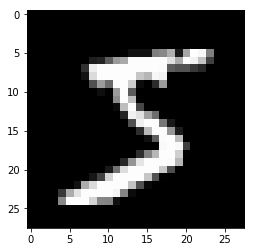

In [20]:
plt.imshow(train_x_array[0])

In [21]:
# using same indices as pytorch dataloader
valid_x_array, valid_y_array = train_x_array[valid_idxs], train_y_array[valid_idxs]
train_x_array, train_y_array = train_x_array[train_idxs], train_y_array[train_idxs]

In [22]:
tfms = tfms_from_stats(inception_stats, sz=sz)

model_data = ImageClassifierData.from_arrays(PATH, 
    (train_x_array, train_y_array), (valid_x_array, valid_y_array),
    bs=bs, tfms=tfms, num_workers=2, test=None)

In [79]:
x,y = next(iter(model_data.trn_dl))

NotImplementedError: uint8

Wait... 
```
elif a.dtype in (np.float32 np.float64):
    ...
else: raise NotImplementedError(a.dtype)
```
$\longrightarrow$
```
NotImplementedError: uint8
```

Why is the datatype an 8-bit unsigned integer? I'll put a `print` statement in `T(..)`:

In [82]:
x,y = next(iter(model_data.trn_dl))

(64, 3, 28, 28)
(64,)


NotImplementedError: uint8

Aha. It's breaking on the labels. So far I have a temporary fix for the image dimensions, but I think I had Fastai working on grayscale-data so I have to look at this again. So.. the labels need to be floats. Got it.

### Converting labels to float32:

In [23]:
train_y_array

array([9, 2, 0, ..., 6, 0, 6], dtype=uint8)

In [24]:
train_y_array = train_y_array.astype(np.float32); train_y_array

array([9., 2., 0., ..., 6., 0., 6.], dtype=float32)

In [25]:
tfms = tfms_from_stats(inception_stats, sz=sz)

model_data = ImageClassifierData.from_arrays(PATH, 
    (train_x_array, train_y_array), (valid_x_array, valid_y_array),
    bs=bs, tfms=tfms, num_workers=2, test=None)

In [94]:
x,y = next(iter(model_data.trn_dl))

(64, 3, 28, 28)
(64,)


In [96]:
x[0]


(0 ,.,.) = 
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1
      ...         ⋱        ...      
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1

(1 ,.,.) = 
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1
      ...         ⋱        ...      
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1

(2 ,.,.) = 
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1
      ...         ⋱        ...      
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1
   -1   -1   -1  ...    -1   -1   -1
[torch.FloatTensor of size 3x28x28]

Okay that worked. Now just to make sure I can denormalize and display an image, and maybe also check I can run a learning-rate finder. Then time to return to the image-dimensions issue.

### De/Normalizing Images

In [98]:
img = model_data.trn_ds.denorm(to_np(x))

AttributeError: 'ArraysIndexDataset' object has no attribute 'denorm'

Oh.. in fastai/dataset.py `ArraysIndexDataset` actually doesn't have a way to denormalize data. Building Model Data via `from_paths` or `from_csv` works because they use a `FilesIndexArrayDataset` which has that method, but `from_arrays` uses `ArraysIndexDataset` which doesn't. I think I remember talk that `from_arrays` was not as complete as the other Model Data construction methods? Anyway I can do it manually.

Yeah it's as simple as:

```
class Normalize():
    ...
        x = (x - self.m) / self.s
    ...
```

```
class Denormalize():
    ...
        return x * self.s + self.m
    ...
```

In [70]:
m = np.array([0.5, 0.5, 0.5])
s = np.array([0.5, 0.5, 0.5])

to_np(x[0]) * s + m

ValueError: operands could not be broadcast together with shapes (3,28,28) (3,) 

In [73]:
to_np(x[0])

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)

In [71]:
to_np(x[0]) * s[0] + m[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

The weird thing is this is the exact line being called, and after a lot of print statements (jupyter kernel kept crashing during pdb debugging) I've confirmed as well I could that the `x` being operated on was indeed a (3,28,28) ndarray ((28,28) if I don't triple-stack channels when creating Model Data) of dtype float32, and `self.m` and `self.s` where both (3,) ndarrays of value [0.5, 0.5, 0.5]...

So.. the broadcasting *is* working inside.. but when I try it out here I keep getting broadcast errors... It's only if I use the 1st dim of `s` and `m`: both scalar `0.5` that I'm able to De/Normalize the tensor...

So I don't know why it's working internally when I can't get it working here, and why things are failing when I either pass in a 1x28x28 or a 28x28 -shaped image tensor..

The exact lines `transforms.py`:
```
class Denormalize():
    """ De-normalizes an image, returning it to original format.
    """
    def __init__(self, m, s):
        self.m=np.array(m, dtype=np.float32)
        self.s=np.array(s, dtype=np.float32)
    def __call__(self, x): return x*self.s+self.m
    
    
class Normalize():
    """ Normalizes an image to zero mean and unit standard deviation, given the mean m and std s of the original image """
    def __init__(self, m, s, tfm_y=TfmType.NO):
        self.m=np.array(m, dtype=np.float32)
        self.s=np.array(s, dtype=np.float32)
        self.tfm_y=tfm_y

    def __call__(self, x, y=None):
        x = (x-self.m)/self.s
        if self.tfm_y==TfmType.PIXEL and y is not None: y = (y-self.m)/self.s
        return x,y
```        


In [75]:
to_np(x[0][0]).shape

(28, 28)

In [80]:
next(iter(trainloader))[0].shape # batch <--> list[batch[image]]

torch.Size([64, 1, 28, 28])

In [76]:
next(iter(trainloader))[0][0].shape

torch.Size([1, 28, 28])

In [82]:
x,y = next(iter(model_data.trn_dl))

In [83]:
x.shape

torch.Size([64, 3, 28, 28])

In [149]:
 A([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

[array([0.5, 0.5, 0.5]), array([0.5, 0.5, 0.5])]

Oh but isn't that interesting... `model_data.trn_dl` should be giving me `torch.Size([64, 1, 28, 28])`, but things break before that point if I don't triple-stack channels.. I'll dive into that after I confirm I can display a *manually* denormalized picture:

In [86]:
to_np(x[0]).shape

(3, 28, 28)

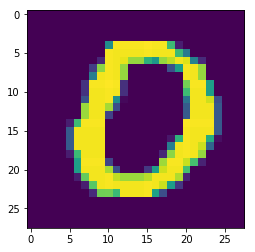

In [88]:
plt.imshow(to_np(x[0][0]) * s[0] + m[0]); # (28,28)

In [155]:
to_np(x[0][0,:]).shape

(28, 28)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


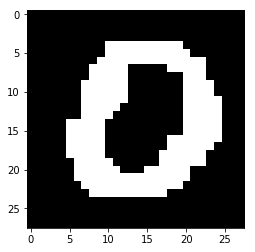

In [147]:
plt.imshow(np.moveaxis(to_np(x[0]), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


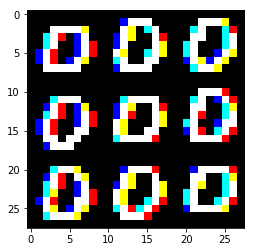

In [112]:
plt.imshow(np.reshape(to_np(x[0]), (28,28,3)))

Something is going horribly wrong.

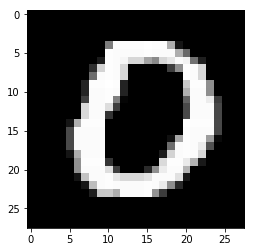

In [179]:
plt.imshow(to_np(x[0][0]), cmap='gray');

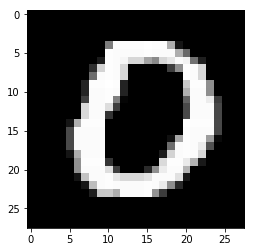

In [180]:
plt.imshow(to_np(x[0][1]), cmap='gray');

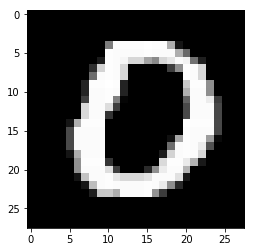

In [181]:
plt.imshow(to_np(x[0][2]), cmap='gray');

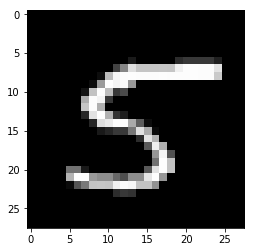

In [182]:
plt.imshow(to_np(x[1][0]), cmap='gray');

Oh got it. Each dimension is a copy, like I made it. The confusing thing is why the `train_x_array[0]` way looks just like the `(28,28)` image even though it's `(28,28,3)`. But that's what I'm feeding into `ImageClassifierData` to create `model_data`... is what's going in different than what's coming out?

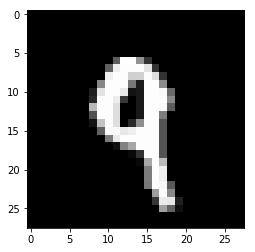

In [183]:
plt.imshow(train_x_array[0])

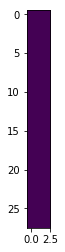

In [184]:
plt.imshow(train_x_array[0])

In [203]:
train_x_array[0,:,:,0].shape

(28, 28)

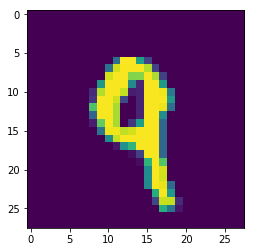

In [204]:
plt.imshow(train_x_array[0,:,:,0])

Hmm..

You think the fact that [pretrained PyTorch models are expecting 3-channel input](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L101) may have ***anything at all*** to do with things?

Oy.

So last thing left to do is to check what a grayscale-converted image looks like.

In [205]:
blah_img = Image.open('DBufwlqW0AEZlBJ.jpg')

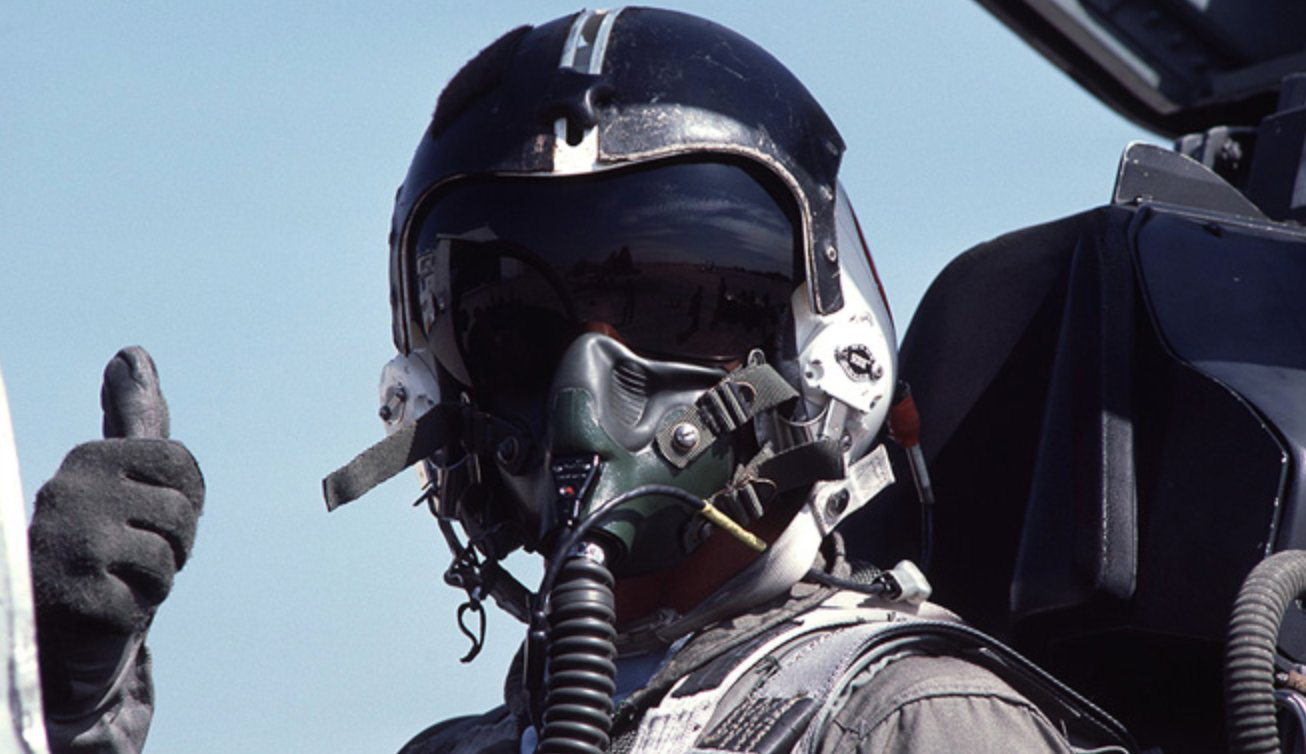

In [206]:
blah_img

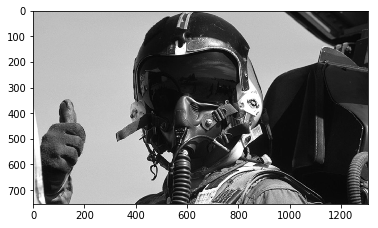

In [227]:
gray_img = cv2.imread('DBufwlqW0AEZlBJ.jpg', 0)
# gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)
# gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray');

In [229]:
gray_img.shape

(754, 1306)

Oh dear god there are no color channels...

Okay. So.. the (28,28,3) image that didn't look like it's contrast was set to max.. was that also just each channel copied? *Wait*.. of course it was because *I did that*.

**Aside**: the problem with working on a  problem for 11 going 12 hours is forgetting things from earlier in the day...

**`train_x_array[0]`**:

In [234]:
train_x_array[0].shape

(28, 28, 3)

In [235]:
train_x_array[0,:,:,0].shape

(28, 28)

In [243]:
np.unique(train_x_array[0,:,:,0] == train_x_array[0,:,:,1]), np.unique(train_x_array[0,:,:,0] == train_x_array[0,:,:,2])

(array([ True]), array([ True]))

Yup.

**`to_np(x[0])`**:

In [245]:
to_np(x[0]).shape

(3, 28, 28)

In [246]:
to_np(x[0][0]).shape

(28, 28)

In [247]:
to_np(x[0][1]).shape

(28, 28)

the next two are equivalent slicings (..I hope)

In [252]:
to_np(x)[0,0,:,:].shape

(28, 28)

In [253]:
to_np(x[0])[0,:,:].shape

(28, 28)

In [263]:
np.unique(to_np(x[0])[0,:,:] == to_np(x[0])[1,:,:]), np.unique(to_np(x[0])[0,:,:] == to_np(x[0])[2,:,:])

(array([ True]), array([ True]))

Yup.

## Final Notes

*.. or why we lost the war.*

I thought I'd start this notebook to learn about dataloaders and instead I learned about tensor dimensions and architecture.

**1. Architecture**

Convnets are confusing and extremely straightforward. Starting this, I was confused about how the filters deal with color channels. The answer is they don't care. They don't care that they're *color* channels that is. To a Convnet, it's all just filters. The R,G,B color input of an image are just 3 'filters' of a certain size with some values. Each Conv layer still follows its job of `filters_in` $\rightarrow$ `filters_out`.

Now, I'm still not exactly sure if each filter looks through all of the filters (ie channels, ie the 'full volume') of the tensor before it – I think they do – but the end result still holds: the 'standard' convolutional operation that goes on inside the conv block *also* goes on with regards to the initial input image tensor.

Meaning a model set up to take in 3 color channels ***will not*** accept only 1! The reason why I had no problem with my custom architecture in straight pytorch was because it's first layer was built to accept a single channel. It would not work with color data. The resnet learners' [architecture takes in 3 channels](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L101).

So, either copy-stack the grayscale image to have 3 channels, or have the 2 extra channels be equal to the mean & standard deviation of the dataset (or experiment with random noise w/ the same mean & stdev?).

**2. Tensor Broadcasting (DataLoader)**

A big problem on its own was the Fast.ai **DataLoader**. It was doing its job, but my misunderstanding of how De/Normalization and Tensor Broadcasting worked cost me more than several hours.

Without fully understanding normalization, I thought it was something very complicated. It isn't. You take 2 numbers, the mean and standard deviation of the dataset, and divide the input data with the 2nd and subtract from it the 1st to Normalize it. Do the opposite (multiply by stdev, add mean) to Denormalize. If you have 3 color channels, you have 2 numbers for each of those channels.

My confusion came in not understanding how those 3 sets of numbers applied to data with only 1 channel. [Soumith Chintala – the Lead Developer of PyTorch – himself stated that the value choice was arbitrary](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/7?u=wnixalo) and only meant to make the tutorials less confusing! There he's talking about CIFAR-10, but he also mentions MNIST earlier.

Regardless, somehow the PyTorch DataLoader is figuring out how to apply the 3-channel normalization values to the 1-channel dataset. It could be it takes the average, or just the first of the 3 values. It doesn't really matter in this case. What's more important is that *it seems the Fast.ai library is currently setup for 3-channel image data*. So while PyTorch will give you a nice 64x1x28x28 normalized tensor, Fast.ai will look at the data missing channels and say "what the hell is going on?".

**Tensor Broadcasting** was the other thing I didn't understand. If I did, I'd've been able to solve all this *much* quicker. Broadcasting 3 and 1 dimensional tensors requires the length of the 3D Tensor's last dimension to be equal to the 1D Vector's length.

This is why the Fast.ai Model Data object's DataLoader was throwing errors when I tried to pull data from it. 

> **NOTE**: **Fast.ai uses `NHWC` dim ordering.** [**PyTorch uses `NCHW`**](https://discuss.pytorch.org/t/swap-axes-in-pytorch/970/2?u=wnixalo). OpenCV and pyplot also use **`HWC`** ordering. *This has been the cause of a lot of confusion for me.*

This is solved by simply ensuring the data arrays you send into `ImageClassifierData` have their dimensions in **`NHWC`** ordering. For MNIST that may look something like (51000, 28, 28, 3).

Do that, do everything else in the usual Fast.ai way, and you'll be able to retrieve data and run a Learner no problem. An example of that is below:

In [356]:
fnames = [o for o in os.listdir(PATH) if 'ubyte.gz' in o] # could just use glob

trn_x_idx = [i for i,s in enumerate(fnames) if 'train-imag' in s][0]
trn_y_idx = [i for i,s in enumerate(fnames) if 'train-lab' in s][0]

# load entire IDX files into memory as ndarrays
train_x_array = read_IDX(PATH/fnames[trn_x_idx])
train_y_array = read_IDX(PATH/fnames[trn_y_idx]).astype(np.float32)

In [357]:
# using same indices as pytorch dataloader
valid_x_array, valid_y_array = train_x_array[valid_idxs], train_y_array[valid_idxs]
train_x_array, train_y_array = train_x_array[train_idxs], train_y_array[train_idxs]

In [358]:
train_x_array = np.stack((train_x_array, train_x_array, train_x_array), axis=-1)
train_x_array.shape

(51000, 28, 28, 3)

In [359]:
tfms = tfms_from_stats(inception_stats, sz=sz)

model_data = ImageClassifierData.from_arrays(PATH, 
    (train_x_array, train_y_array), (valid_x_array, valid_y_array),
    bs=bs, tfms=tfms, num_workers=2, test=None)

In [360]:
x,y = next(iter(model_data.trn_dl))

**NOTE** that the PyTorch Tensors are in PyTorch `NCHW` ordering.

In [361]:
x.shape, y.shape

(torch.Size([64, 3, 28, 28]), torch.Size([64]))

**NOTE** also that the Fast.ai library (as of 22 May 2018) is still in beta. ModelData datasets created via `.from_paths` or `.from_csv` will be of type `FilesArrayDataset`, a [subset of `FilesDataset`](https://github.com/fastai/fastai/blob/master/fastai/dataset.py#L235) which has a `denorm` method that automatically denormalizes a minibatch of data and rolls its axes from `NCHW` $\rightarrow$ `NHWC` format, allowing you to immediately display the image.

Datasets (eg: `model_data.trn_ds`) created via `.from_arrays` will be of type `ArraysIndexDataset`, a subset of `ArraysDataset` which *does not* have the `denorm` method. So.. when you pull an image like I've been doing, the dimension ordering is still in PyTorch format – you'll have to take care of yourself like so:

In [363]:
model_data.trn_ds

In [365]:
np.rollaxis(to_np(x),1,4).shape

(64, 28, 28, 3)

---

### 1 channel (28,28) Slice:

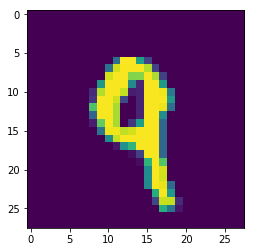

In [267]:
plt.imshow(train_x_array[0,:,:,0]);

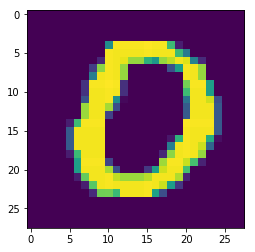

In [273]:
plt.imshow(to_np(x)[0,0,:,:]);

### 3 channels (28,28,3):

I have to remember `pyploy.imshow` takes a (H,W,3) ordered image.

In [271]:
train_x_array[0].shape

(28, 28, 3)

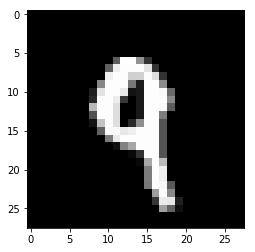

In [274]:
plt.imshow(train_x_array[0]);

In [280]:
tmp = to_np(x[0])[0]
tmp = np.stack((tmp,tmp,tmp), axis=2)
tmp.shape

(28, 28, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


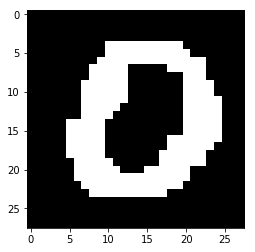

In [281]:
plt.imshow(tmp)

Oh I am a fool. This is not in the correct number range for pyplot....

In [284]:
np.max(train_x_array)

255

Yyyyup...

Were the 3 values inside the mean & stdev normalization arrays for the 3 color channels?

In [288]:
np.max(tmp * s[0] + m[0])

255.0

In [290]:
tmp * s + m

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

Oh my god this works. This works. *what better way to learn how the universe works than to crash into it head first... there're probably more than a few..*. Right, so that's how dimensions and broadcasting work.

```
(R, C, N) * (N,) + (N,) = Good
```

```
(N, R, C) * (N,) + (N,) = No.
```

In [321]:
tmp4 = np.concatenate((tmp, np.expand_dims(to_np(x[0][0]), 2)), -1)
tmp4.shape

(28, 28, 4)

In [322]:
m4 = np.concatenate((m, np.array([0.5])), 0)
s4 = np.concatenate((s, np.array([0.5])), 0)
s4.shape

(4,)

In [325]:
(tmp4 * s4 + m4).shape

(28, 28, 4)

And now that Zero should look like it should

In [328]:
tmp = to_np(x[0])[0]
tmp = np.stack((tmp,tmp,tmp), axis=2)
tmp.shape

(28, 28, 3)

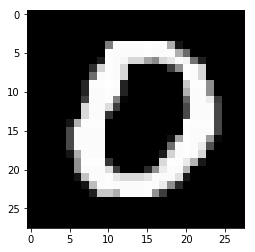

In [332]:
plt.imshow((tmp*s+m).astype(int))

It looks like another big issue is `pyplot.imshow` accepts value ranges of [0,1] for floats, and [0,255] for ints.

Here's the original problem with display the Zero in (C,H,W) format. Axes moved from (C,H,W) $\rightarrow$ (H,W,C), the image tensor is normalized, and finally converted to an integer datatype. Eureka.

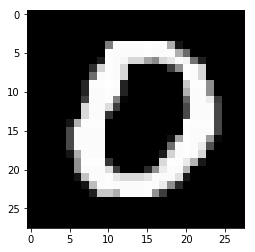

In [335]:
plt.imshow((np.moveaxis(to_np(x[0]), 0, -1) * s + m).astype(int));

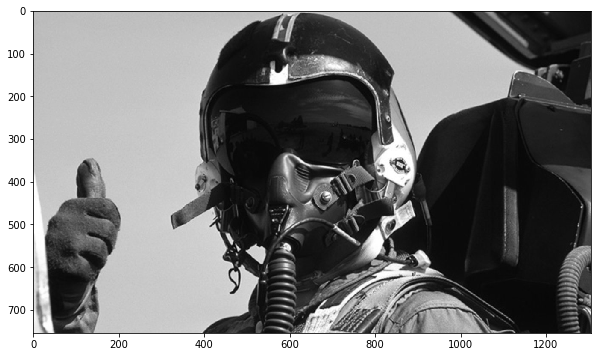

In [340]:
plt.figure(figsize=(10,10))
plt.imshow(gray_img, cmap='gray');